In [1]:
import json
import sys, os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
directory = "data/online"

if not os.path.exists(directory):
    link = "https://www.dropbox.com/scl/fi/nkupgd6mfrxryefdoxxwn/20_30.zip?rlkey=dpwjhieorllwvavfh3le622t8&st=koo7vhx8&dl=1"
    import requests
    import zipfile
    import io

    r = requests.get(link)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(directory)

In [3]:
directory = "data/online/20_30"

# open all json files and parse them
data = []
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        with open(os.path.join(directory, filename)) as f:
            data.append(json.load(f))

In [4]:
# get all the policies
policies = set()
for d in data:
    policies.add(d["policies_names"][0])
policies = list(policies)
policies.sort()
index_policy = {k: i for i, k in enumerate(policies)}

Text(0.5, 0, 'Agent 1 policy')

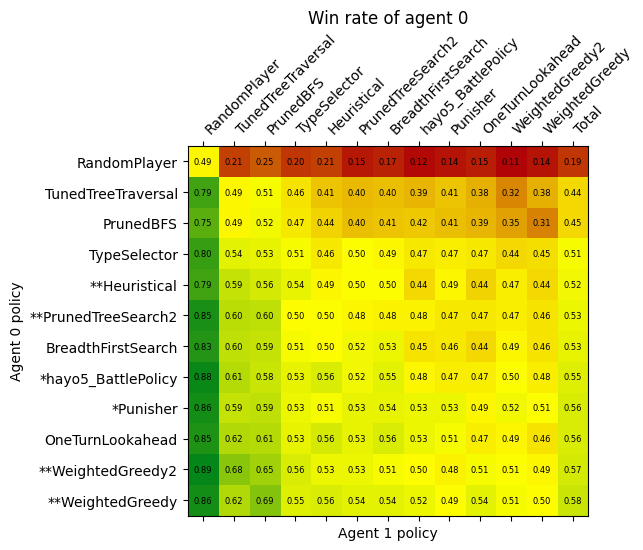

In [5]:
# WIN RATE

# map all data in the grid
# they all the combination of policies versus a different policy
# I want to map them in a grid showing the win rate

# create the grid
grid = np.zeros((len(policies), len(policies)))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    # calculate the win rate
    wins = 0
    for battle in d["battles"]:
        if battle["result"] == 0:
            wins += 1
    grid[x, y] = wins / len(d["battles"])
    grid[y, x] = 1 - grid[x, y]


mean_rate = np.mean(grid, axis=1)

row_order = np.argsort(mean_rate)  
grid = grid[row_order]
ordered_policies = np.array(policies)[row_order]

grid = grid.T  
grid = grid[row_order].T

mean_rate = mean_rate.reshape(-1, 1) 
grid = np.hstack((grid, mean_rate[row_order]))

# Define the custom colormap
colors = ['#b10407', '#ffff00', '#058618']  # R -> Y -> G
n_bins = 100  # Discretize the interpolation into bins
cmap_name = 'r_y_g'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
n = len(policies)
fig, ax = plt.subplots()
cax = ax.matshow(grid, cmap=cm)
for i in range(n):
    for j in range(n + 1):
        ax.text(j, i, f"{grid[i][j]:.2f}", ha='center', va='center', color='black', fontsize=6)

highlighted_ticks = ['Heuristical', 'PrunedTreeSearch2', 'WeightedGreedy', 'WeightedGreedy2']  
formatted_ticks = [
    f'**{tick}' if tick in highlighted_ticks else f'{tick}' for tick in ordered_policies
]

highlighted_ticks = ['hayo5_BattlePolicy', 'Punisher']  
formatted_ticks = [
    f'*{tick}' if tick in highlighted_ticks else f'{tick}' for tick in formatted_ticks
]


plt.yticks(range(n), formatted_ticks)

x_ticks = list(ordered_policies) + ["Total"]
plt.xticks(range(n+1), x_ticks, rotation=45, ha='left')
#plt.yticks(range(n), policies)
plt.title("Win rate of agent 0")
plt.ylabel("Agent 0 policy")
plt.xlabel("Agent 1 policy")

[3800. 3763. 4067. 3187. 3834. 3999. 1409. 3213. 3678. 4163. 4091. 3998.]
[7200. 7200. 7200. 7200. 7200. 7200. 7200. 7200. 7200. 7200. 7200. 7200.]
[0.52777778 0.52263889 0.56486111 0.44263889 0.5325     0.55541667
 0.19569444 0.44625    0.51083333 0.57819444 0.56819444 0.55527778]


Text(0.5, 0, 'Policy')

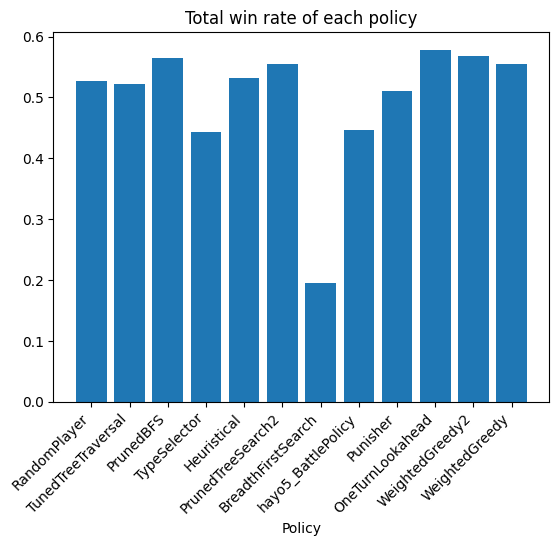

In [6]:
# TOTAL WIN RATE 

# map all data in the grid
# they all the combination of policies versus a different policy
# I want to map them in a grid showing the win rate

win_rate = np.zeros(len(policies))
n_battles = np.zeros(len(policies))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    # calculate the win rate
    wins = 0
    for battle in d["battles"]:
        if battle["result"] == 0:
            wins += 1
    batt = d["n_battles_emulated"]
    win_rate[x] += wins 
    n_battles[x] += batt

    if d["policies_names"][0] != d["policies_names"][1]:
        win_rate[y] += (batt - wins)  
        n_battles[y] += batt

print(win_rate)
print(n_battles)

for i in range(win_rate.shape[0]):
    win_rate[i] /= n_battles[i]

print(win_rate)

ax_x = range(1,len(win_rate)+1)
plt.bar(ax_x, win_rate)
plt.xticks(ax_x, ordered_policies, rotation=45, ha='right')
plt.title("Total win rate of each policy")
plt.xlabel("Policy")

Text(0.5, 0, 'Agent 1 policy')

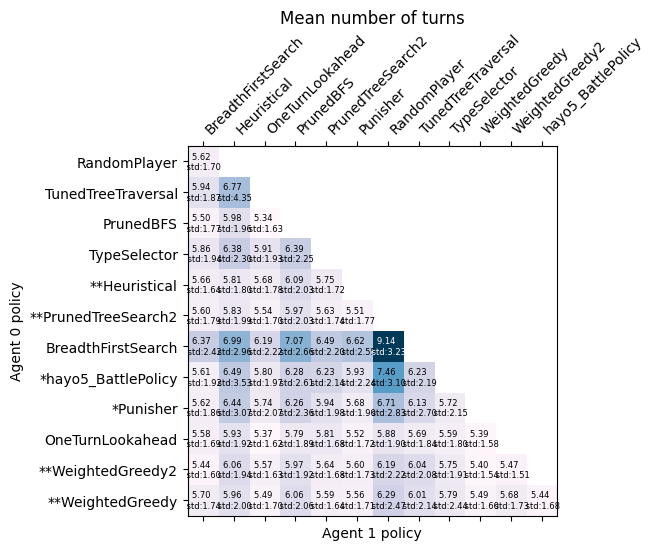

In [ ]:
# MEAN NUMBER OF TURNS

turns = np.zeros((len(policies), len(policies)))
turns_dev = np.zeros((len(policies), len(policies)))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    if x < y:
        x, y = y, x
    turns[y, x] = np.nan
    turns[x, y] = sum(battle["turns"] for battle in d["battles"])/d["n_battles_emulated"]
    turns_dev[y, x] = np.nan
    turns_dev[x, y] = np.std([battle["turns"] for battle in d["battles"]])


n = len(policies)
fig, ax = plt.subplots()
cax = ax.matshow(turns, cmap="PuBu")
for i in range(n):
    for j in range(n):
        if not np.isnan(turns[i, j]): 
            col = 'black'
            if turns[i, j] > 9: col = 'white'
            ax.text(j, i, f"{turns[i, j]:.2f} \n std:{turns_dev[i, j]:.2f}", ha='center', va='center', color=col, fontsize=6)
plt.xticks(range(n), policies, rotation=45, ha='left')
plt.yticks(range(n), formatted_ticks)
plt.title("Mean number of turns")
plt.ylabel("Agent 0 policy")
plt.xlabel("Agent 1 policy")

Text(0.5, 0, 'Agent 1 policy')

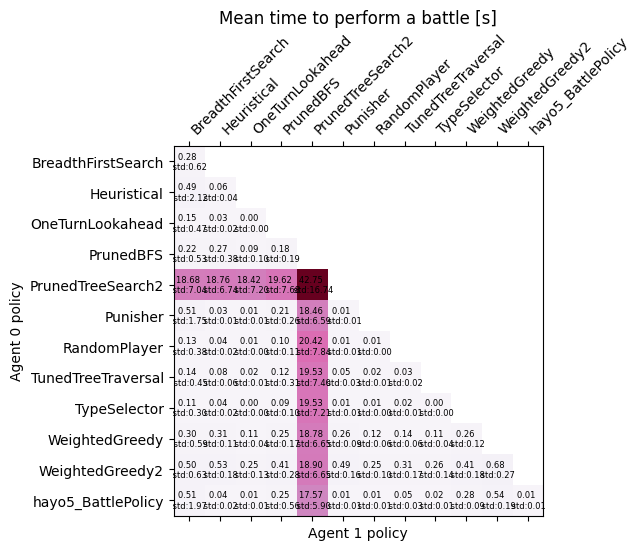

In [ ]:
# MEAN TIME OF A BATTLE

time = np.zeros((len(policies), len(policies)))
time_dev = np.zeros((len(policies), len(policies)))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    if x < y:
        x, y = y, x
    time[y, x] = np.nan
    time[x, y] = sum(battle["total_time"] for battle in d["battles"])/d["n_battles_emulated"]
    time_dev[y, x] = np.nan
    time_dev[x, y] = np.std([battle["total_time"] for battle in d["battles"]])

n = len(policies)
fig, ax = plt.subplots()
cax = ax.matshow(time, cmap="PuRd")
for i in range(n):
    for j in range(n):
        if not np.isnan(time[i, j]): 
            ax.text(j, i, f"{time[i, j]:.2f} \n std:{time_dev[i, j]:.2f}", ha='center', va='center', color='black', fontsize=6)
plt.xticks(range(n), policies, rotation=45, ha='left')
plt.yticks(range(n), policies)
plt.title("Mean time to perform a battle [s]")
plt.ylabel("Agent 0 policy")
plt.xlabel("Agent 1 policy")

[1.85632792e+03 1.90589893e+02 7.26504564e-01 1.03143524e+03
 1.49869516e+05 4.83256578e-01 3.01422119e+00 1.84902582e+02
 1.02092075e+00 1.29597776e+03 2.73173544e+03 1.81731868e+00]
[44476. 48806. 44074. 48245. 45646. 44706. 54319. 48073. 46266. 43691.
 44572. 44714.]
[5.54911024e-05 3.84628756e-03 2.13791116e-02 2.20663285e-05
 3.90505047e-03 3.28330009e+00 4.17377444e-02 4.06431694e-05
 1.08096582e-05 1.64837447e-05 6.12881504e-02 2.96623505e-02]


(4.0, 9.0)

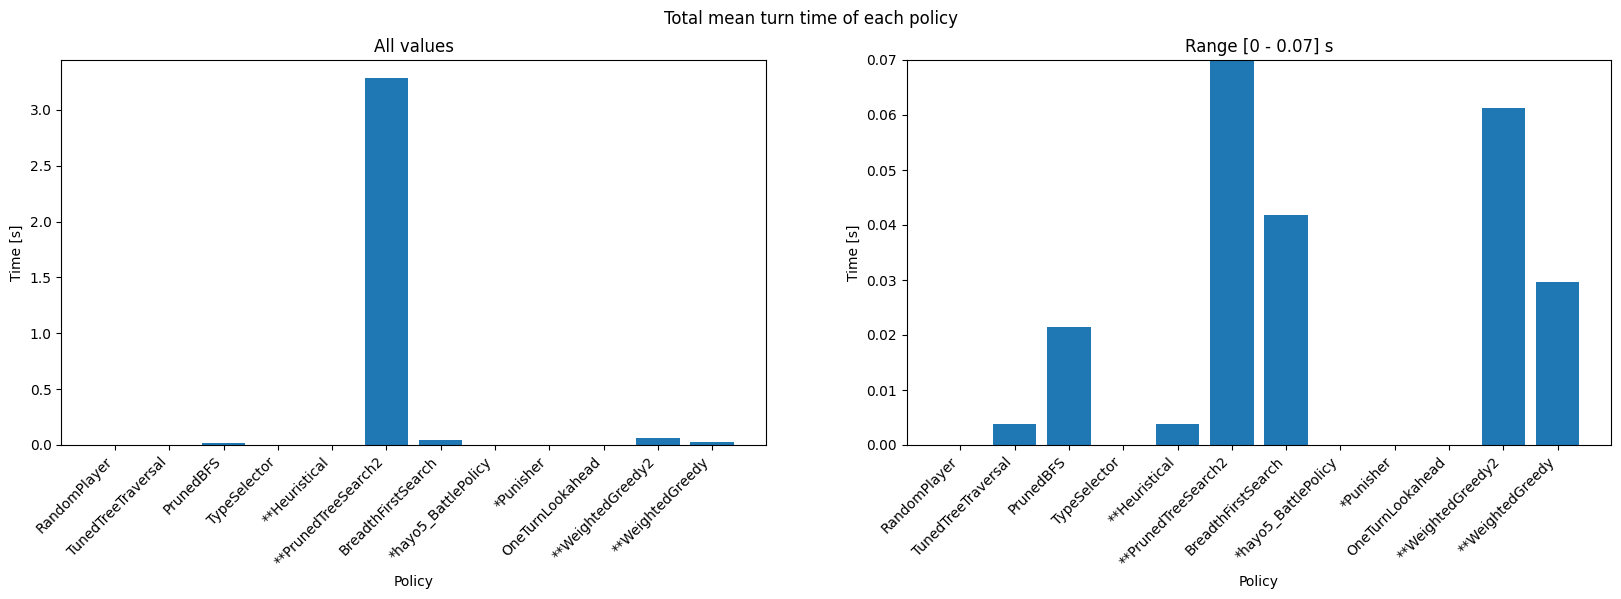

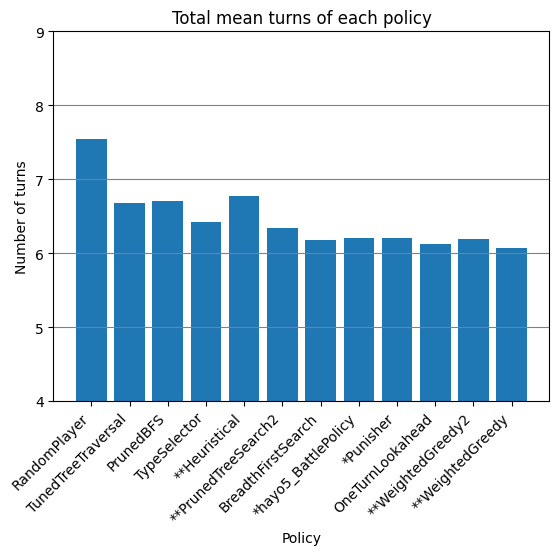

In [ ]:
# MEAN TIME FOR TURN FOR EACH POLICY

tot_time = np.zeros(len(policies))
n_turns = np.zeros(len(policies))

for d in data:
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]

    time0 = 0
    time1 = 0
    tur = 0

    for battle in d["battles"]:
        time0 += sum(battle["turns_time_p1"])
        time1 += sum(battle["turns_time_p2"])
        tur += battle["turns"]
    
    tot_time[x] += time0 
    n_turns[x] += tur

    tot_time[y] += time1
    n_turns[y] += tur

print(tot_time)
print(n_turns)

for i in range(tot_time.shape[0]):
    tot_time[i] /= n_turns[i]
    n_turns[i] /= n_battles[i]

tot_time = tot_time[row_order]
n_turns = n_turns[row_order]
print(tot_time)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
ax_x = range(1,len(tot_time)+1)
plt.bar(ax_x, tot_time)
plt.xticks(ax_x, formatted_ticks, rotation=45, ha='right')
plt.title("All values")
plt.xlabel("Policy")
plt.ylabel('Time [s]')

plt.subplot(1, 2, 2)
ax_x = range(1,len(tot_time)+1)
plt.bar(ax_x, tot_time)
plt.xticks(ax_x, formatted_ticks, rotation=45, ha='right')
plt.title("Range [0 - 0.07] s")
plt.xlabel("Policy")
plt.ylabel('Time [s]')
plt.ylim([0, 0.07])

plt.suptitle("Total mean turn time of each policy")

plt.figure()
for y in [5, 6, 7, 8]:
    plt.axhline(y=y, color='gray', linestyle='-', linewidth=0.8)
ax_x = range(1,len(n_turns)+1)
plt.bar(ax_x, n_turns)
plt.xticks(ax_x, formatted_ticks, rotation=45, ha='right')
plt.title("Total mean turns of each policy")
plt.xlabel("Policy")
plt.ylabel("Number of turns")
plt.ylim([4, 9])


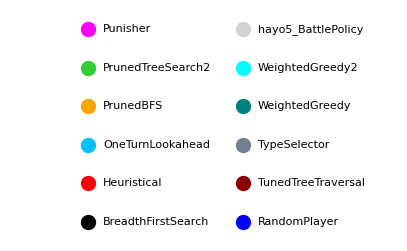

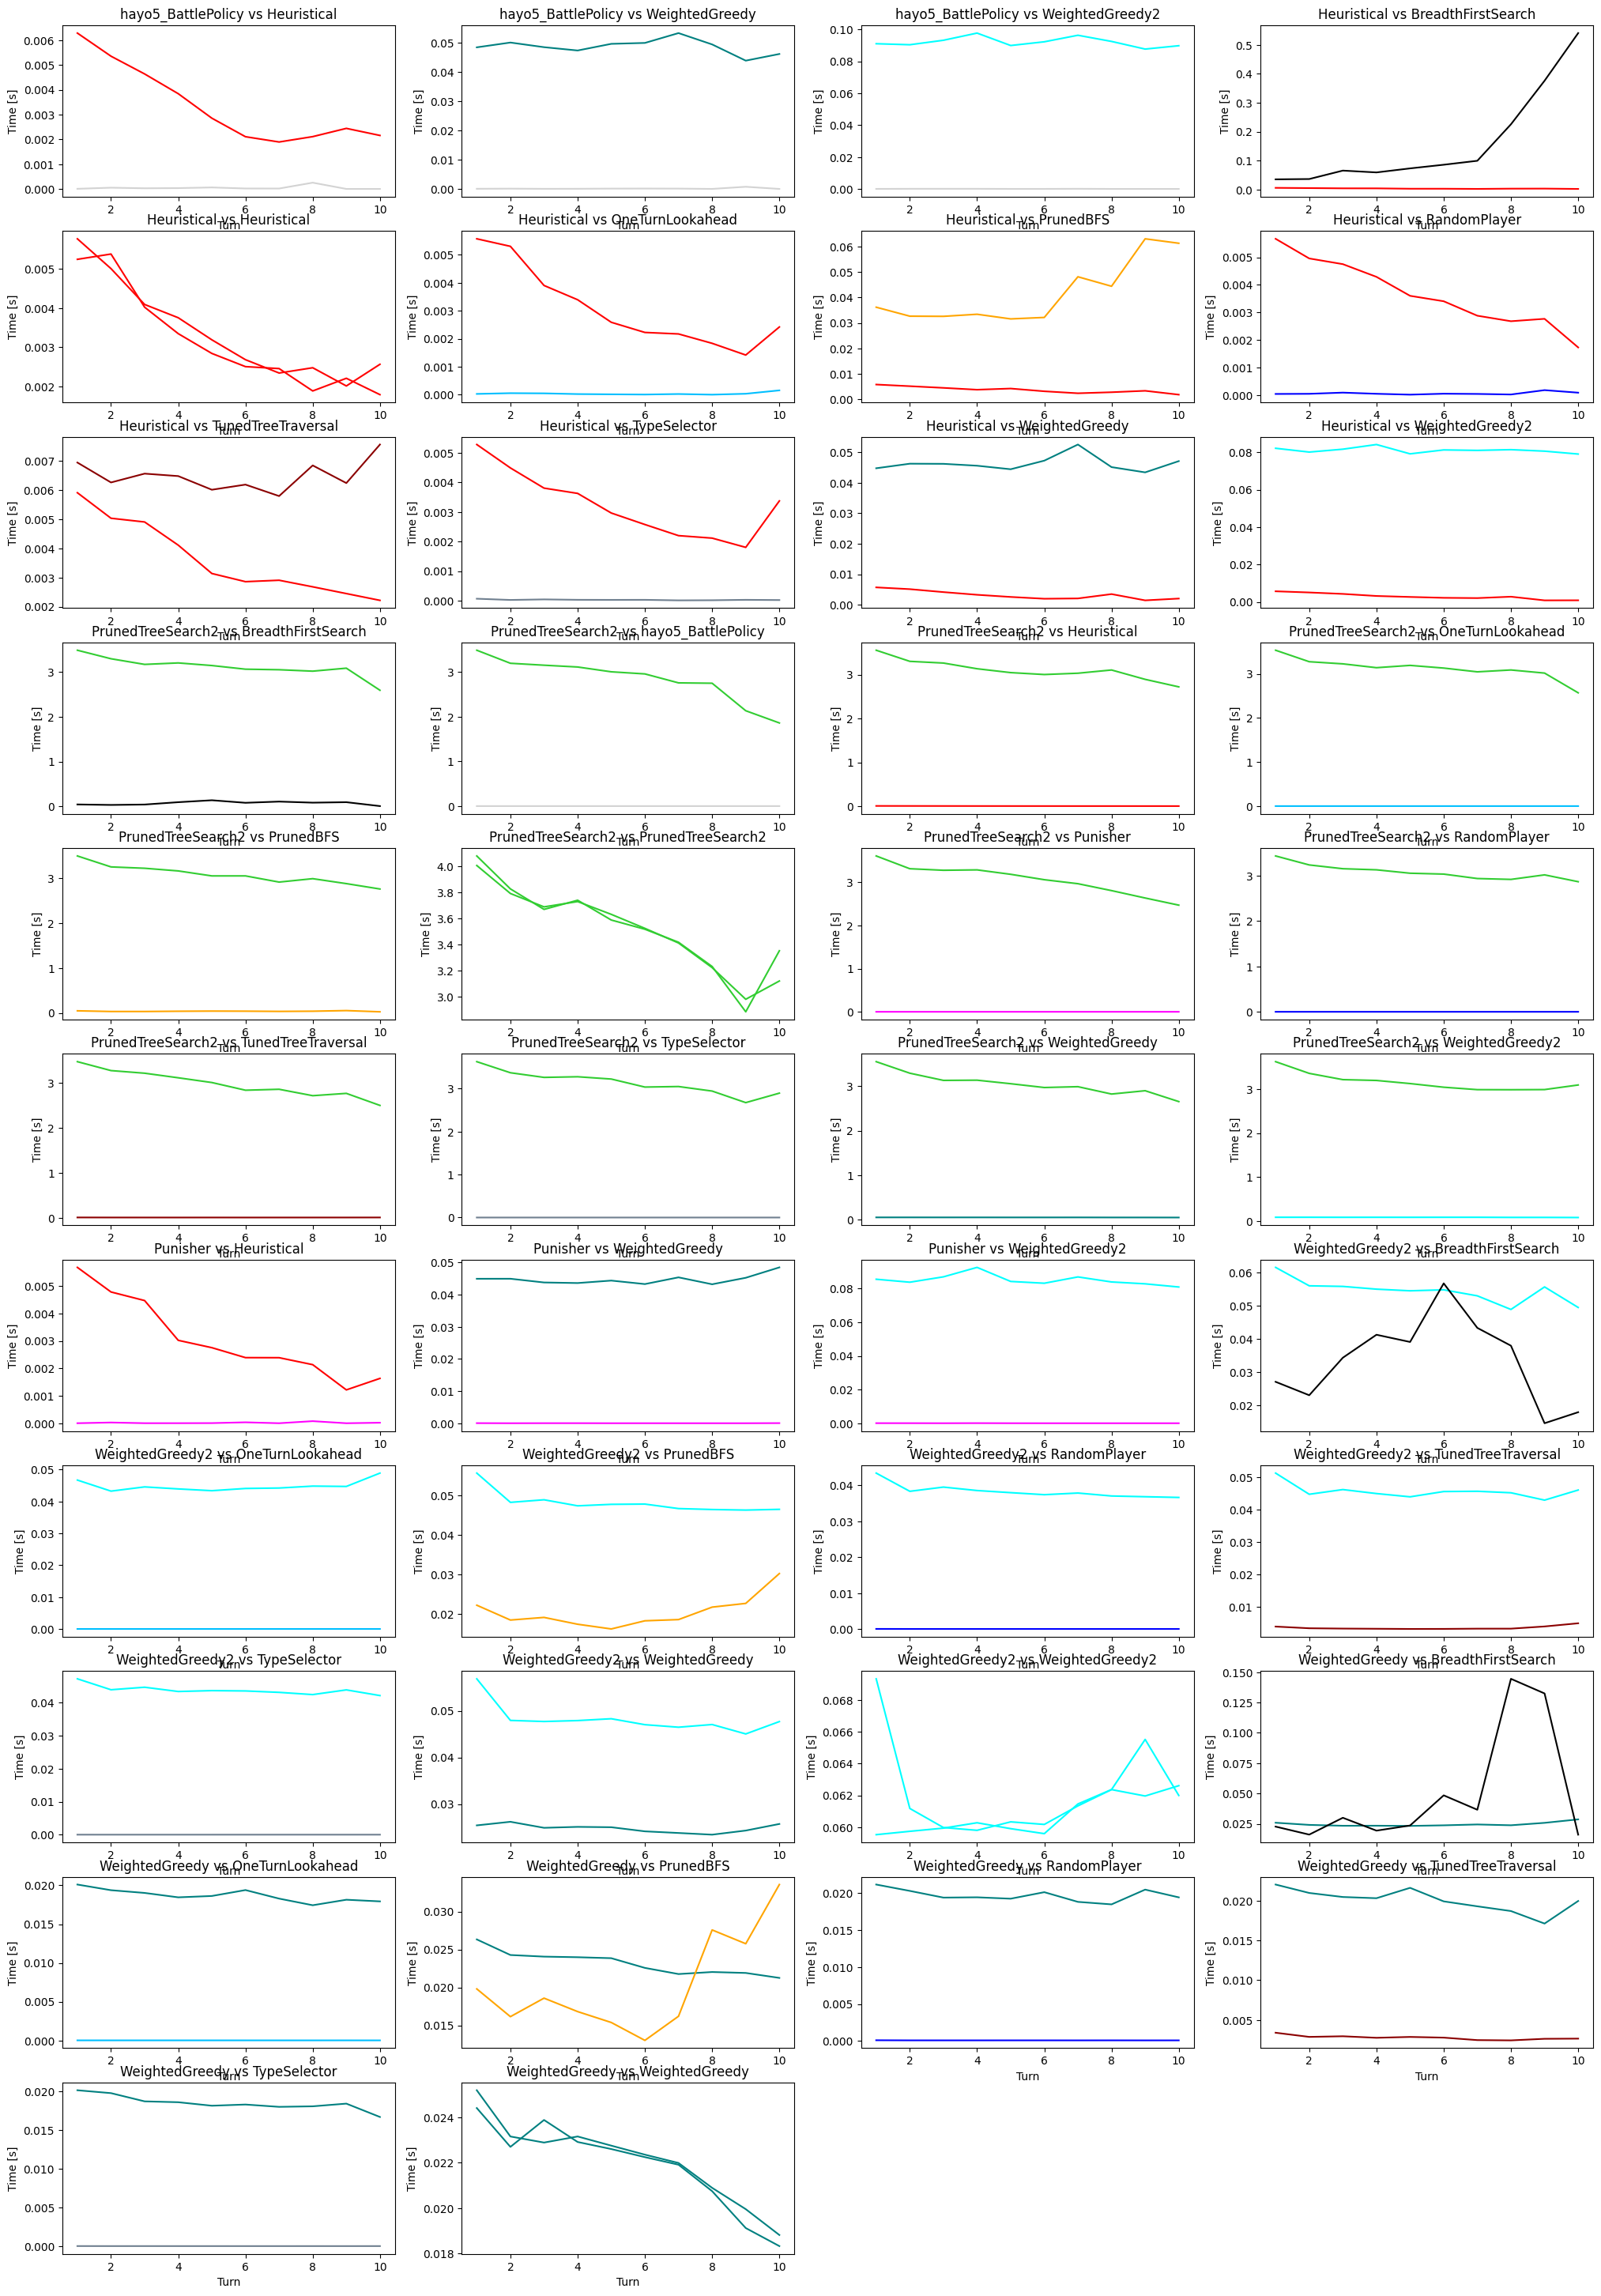

In [25]:
# MEAN TIME FOR EACH TURN 

sys.path.append(os.path.dirname(os.getcwd()))
import utils.scraping_data as s

colors = ["black", "red", "deepskyblue", "orange", "limegreen", "magenta", "blue", "darkred", "slategray", "teal", "cyan", "lightgrey"]

num_rows = (len(colors) + 1) // 2  

plt.figure(figsize=(5, num_rows/2))  

for i, (color, label) in enumerate(zip(colors, policies)):
    col = i // num_rows  
    row = i % num_rows  

    plt.scatter(col, row, color=color, s=100)
    plt.text(col + 0.1, row, label, verticalalignment='center', fontsize=8)

plt.xlim(-0.5, 2)  
plt.ylim(-0.5, num_rows - 0.5)
plt.axis('off')  

n = len(policies)
n_agents = 4

agents = ["Heuristical", "PrunedTreeSearch2", "WeightedGreedy", "WeightedGreedy2"]

tot_comb = n_agents*n

n_col = n_agents
n_row = int(np.ceil(tot_comb/n_col))

plt.figure(figsize=(25, 40))

i = 0

for d in data:

    if all(ag not in agents for ag in [d["policies_names"][0], d["policies_names"][1]]): continue

    avg_turn_time = s.get_avg_turn_time_per_turn(d, max_turn=10)
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    a = [x, y]

    i += 1
    plt.subplot(n_row, n_col, i)

    for j, p in enumerate(avg_turn_time):
        ax_x = range(1,len(p)+1)
        plt.plot(ax_x, p, color=colors[a[j]])
    
    plt.title(d["policies_names"][0]+ " vs " + d["policies_names"][1])
    plt.xlabel("Turn")
    plt.ylabel("Time [s]")


#plt.tight_layout
plt.show()

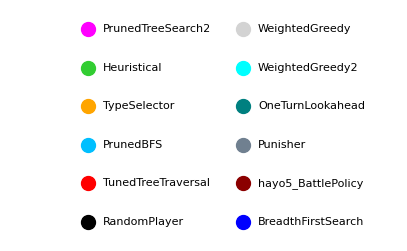

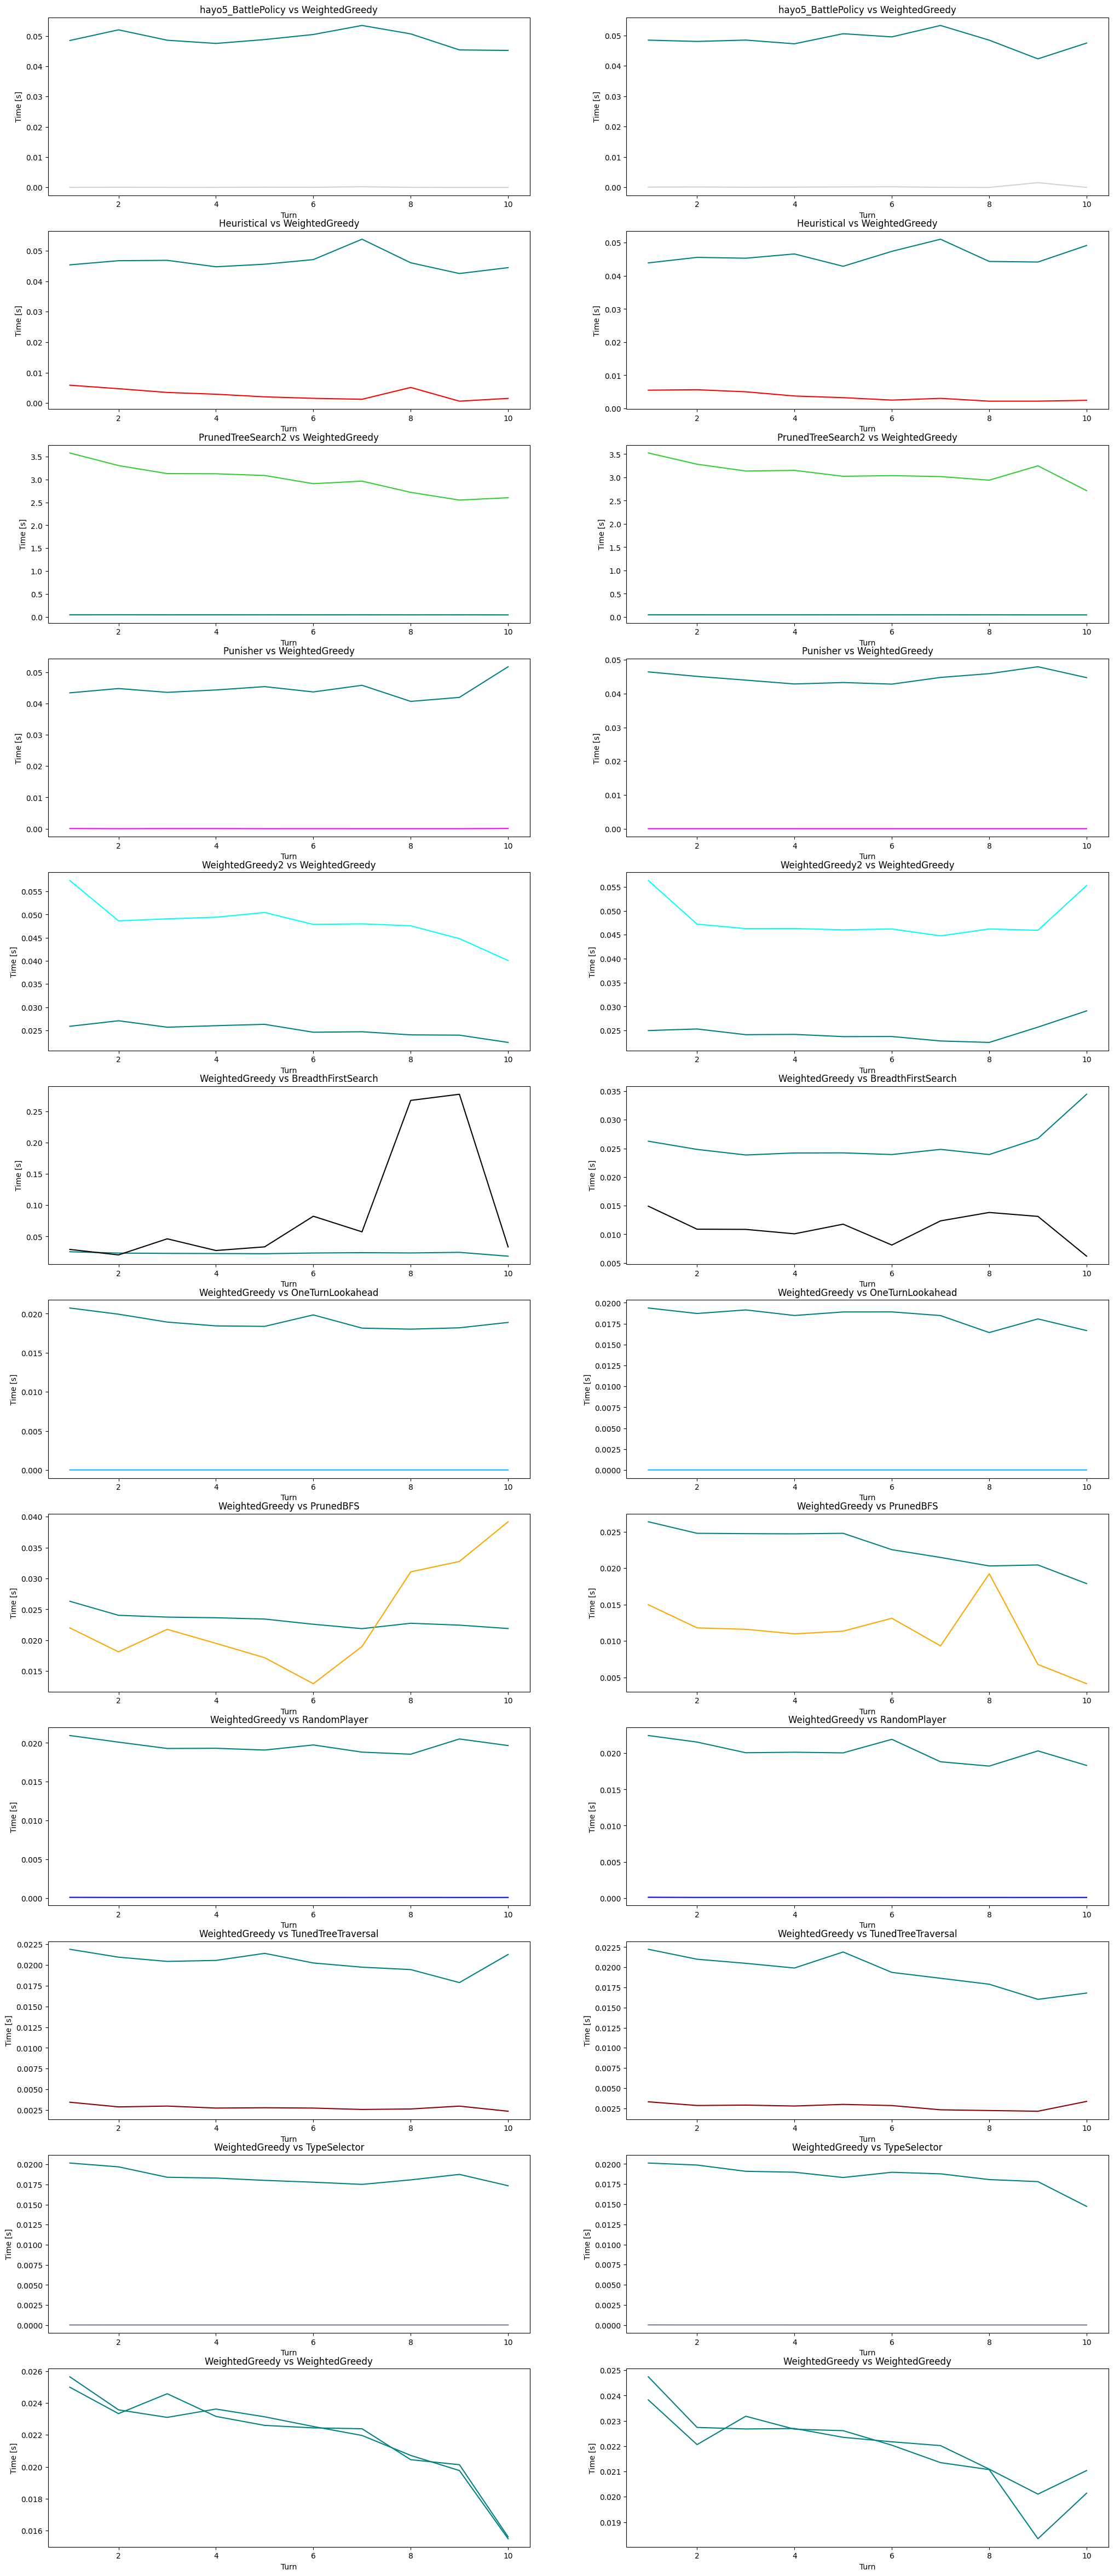

In [24]:
# MEAN TIME FOR EACH TURN - WON/LOST

sys.path.append(os.path.dirname(os.getcwd()))

import utils.scraping_data as s

colors = ["black", "red", "deepskyblue", "orange", "limegreen", "magenta", "blue", "darkred", "slategray", "teal", "cyan", "lightgrey"]

num_rows = (len(colors) + 1) // 2  

plt.figure(figsize=(5, num_rows/2))  

for i, (color, label) in enumerate(zip(colors, ordered_policies)):
    col = i // num_rows  
    row = i % num_rows  

    plt.scatter(col, row, color=color, s=100)
    plt.text(col + 0.1, row, label, verticalalignment='center', fontsize=8)

plt.xlim(-0.5, 2)  
plt.ylim(-0.5, num_rows - 0.5)
plt.axis('off')  

n = len(policies)

agents = ["WeightedGreedy"]
n_agents = len(agents)

tot_comb = n_agents*n

n_col = 2
n_row = tot_comb

plt.figure(figsize=(25, 60))

i = 0

for d in data:
    if all(ag not in agents for ag in [d["policies_names"][0], d["policies_names"][1]]): continue

    if d["policies_names"][0] == agents[0]: pl = 0
    else: pl = 1

    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    a = [x, y]

    i += 1
    plt.subplot(n_row, n_col, i)
    avg_turn_time = s.get_avg_turn_time_per_turn(d, max_turn=10, battle_type="won", player=pl)
    
    for j, p in enumerate(avg_turn_time):
        ax_x = range(1,len(p)+1)
        plt.plot(ax_x, p, color=colors[a[j]])

    plt.title(d["policies_names"][0]+ " vs " + d["policies_names"][1])
    plt.xlabel("Turn")
    plt.ylabel("Time [s]")

    i += 1
    plt.subplot(n_row, n_col, i)
    avg_turn_time = s.get_avg_turn_time_per_turn(d, max_turn=10, battle_type="lost", player=pl)
    
    for j, p in enumerate(avg_turn_time):
        ax_x = range(1,len(p)+1)
        plt.plot(ax_x, p, color=colors[a[j]])
    
    plt.title(d["policies_names"][0]+ " vs " + d["policies_names"][1])
    plt.xlabel("Turn")
    plt.ylabel("Time [s]")


#plt.tight_layout
plt.show()

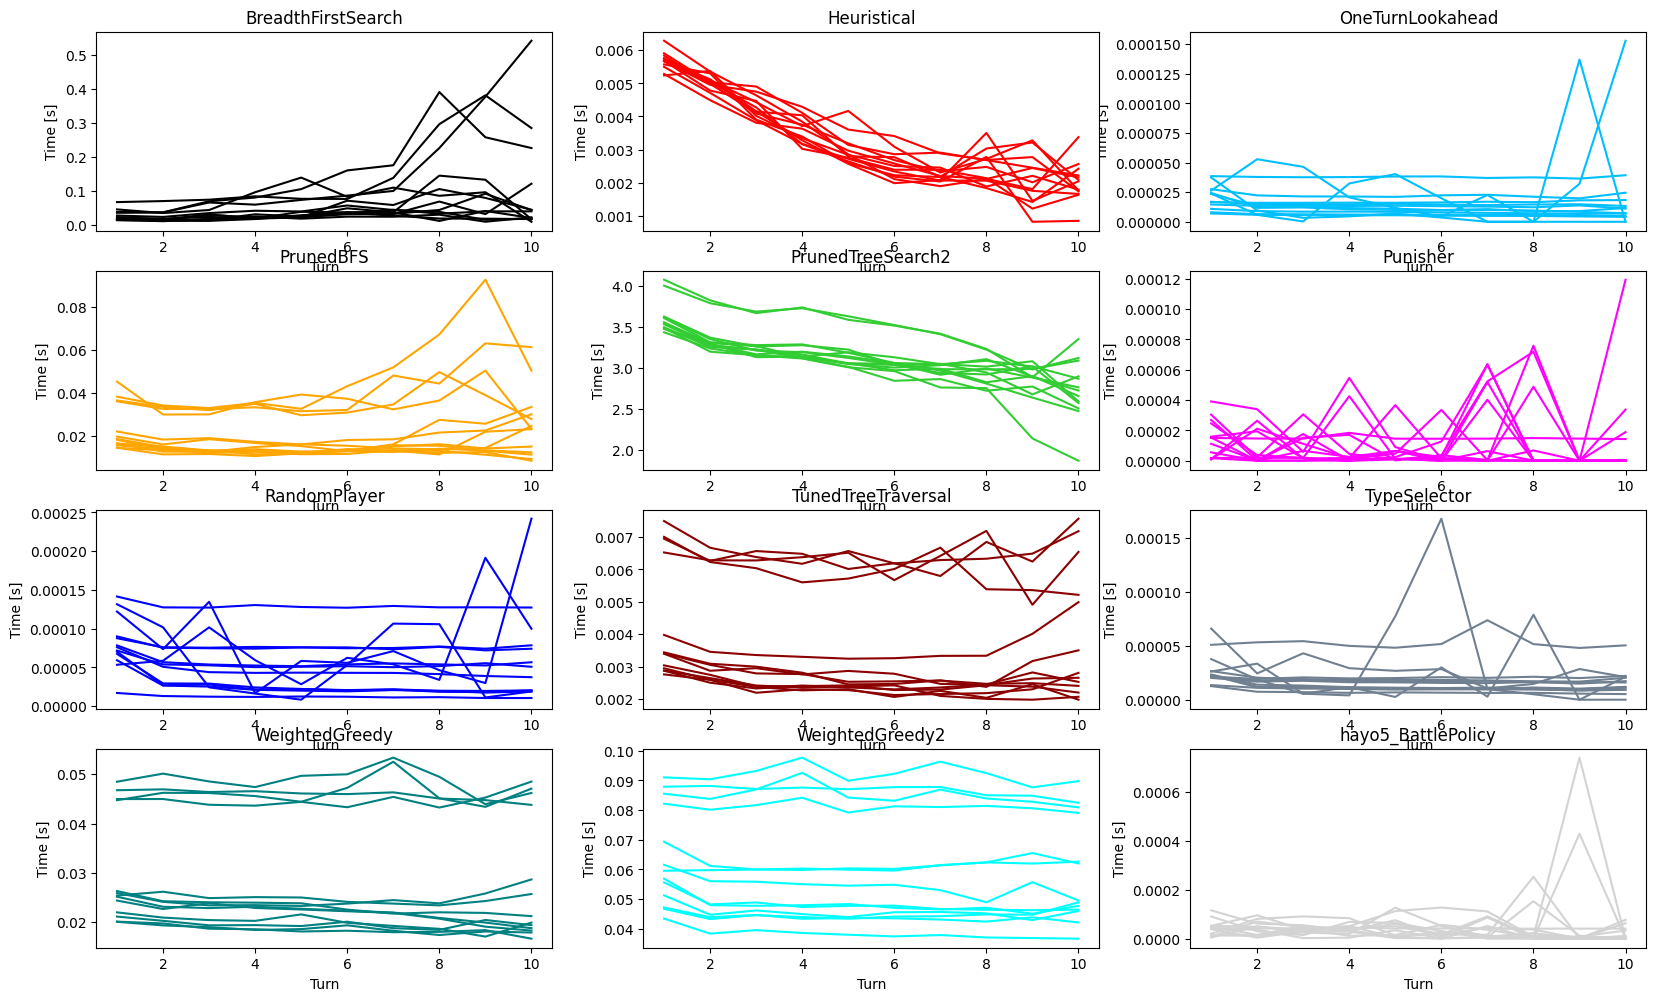

In [26]:
# MEAN TIME FOR EACH TURN - DIVIDED 

n_col = 3
n_row = int(np.ceil((n + 1) / n_col))

plt.figure(figsize=(20, 15))

for i, d in enumerate(data):
    avg_turn_time = s.get_avg_turn_time_per_turn(d, max_turn=10)
    x, y = index_policy[d["policies_names"][0]], index_policy[d["policies_names"][1]]
    a = [x, y]

    for j, p in enumerate(avg_turn_time):
        ax_x = range(1,len(p)+1)
        plt.subplot(n_row, n_col, a[j]+1)
        plt.plot(ax_x, p, color=colors[a[j]])
        plt.title(d["policies_names"][j])
        plt.xlabel("Turn")
        plt.ylabel("Time [s]")
        
plt.show()

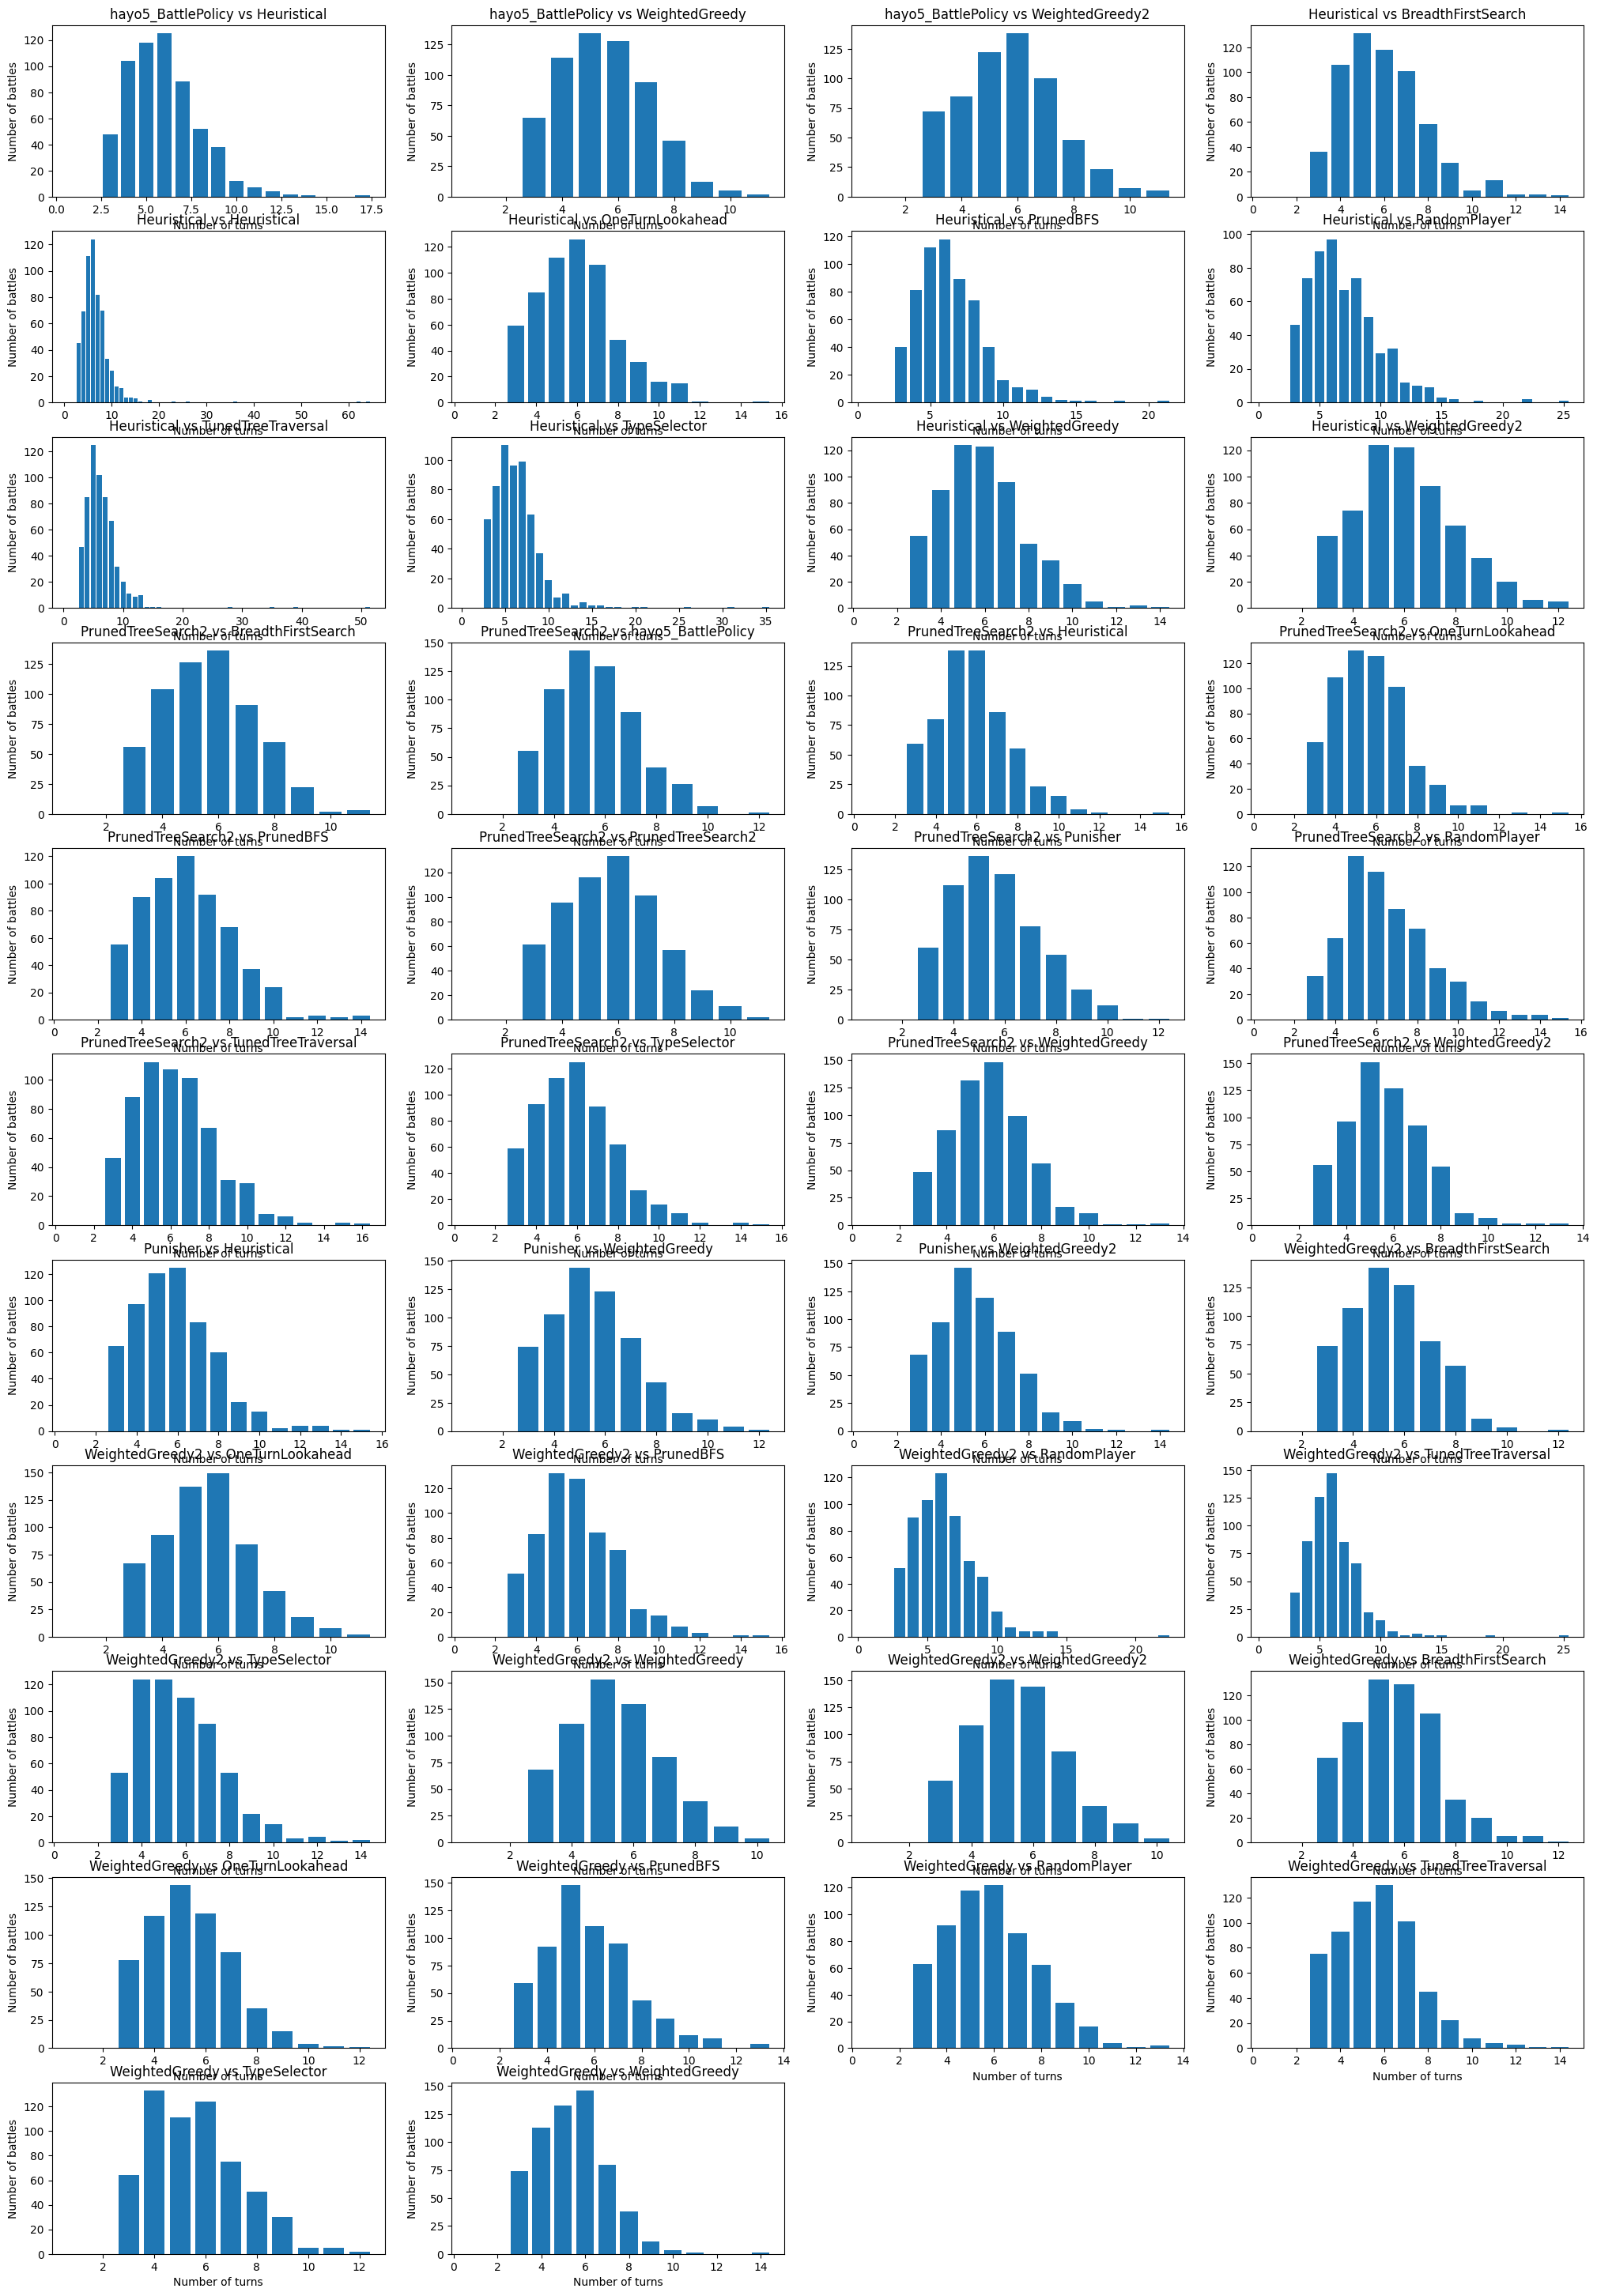

In [27]:
# NUMBER OF TURNS

n = len(policies)
n_agents = 4

agents = ["Heuristical", "PrunedTreeSearch2", "WeightedGreedy", "WeightedGreedy2"]

tot_comb = n_agents*n

n_col = n_agents
n_row = int(np.ceil(tot_comb/n_col))

plt.figure(figsize=(25, 40))

i = 0

for d in data:
    if all(ag not in agents for ag in [d["policies_names"][0], d["policies_names"][1]]): continue
    games_per_turn = s.get_games_per_turn_count(d)

    i += 1
    plt.subplot(n_row, n_col, i)

    ax_x = range(1,len(games_per_turn)+1)
    plt.bar(ax_x, games_per_turn)
    
    plt.title(d["policies_names"][0]+ " vs " + d["policies_names"][1])
    plt.xlabel("Number of turns")
    plt.ylabel("Number of battles")

plt.show()

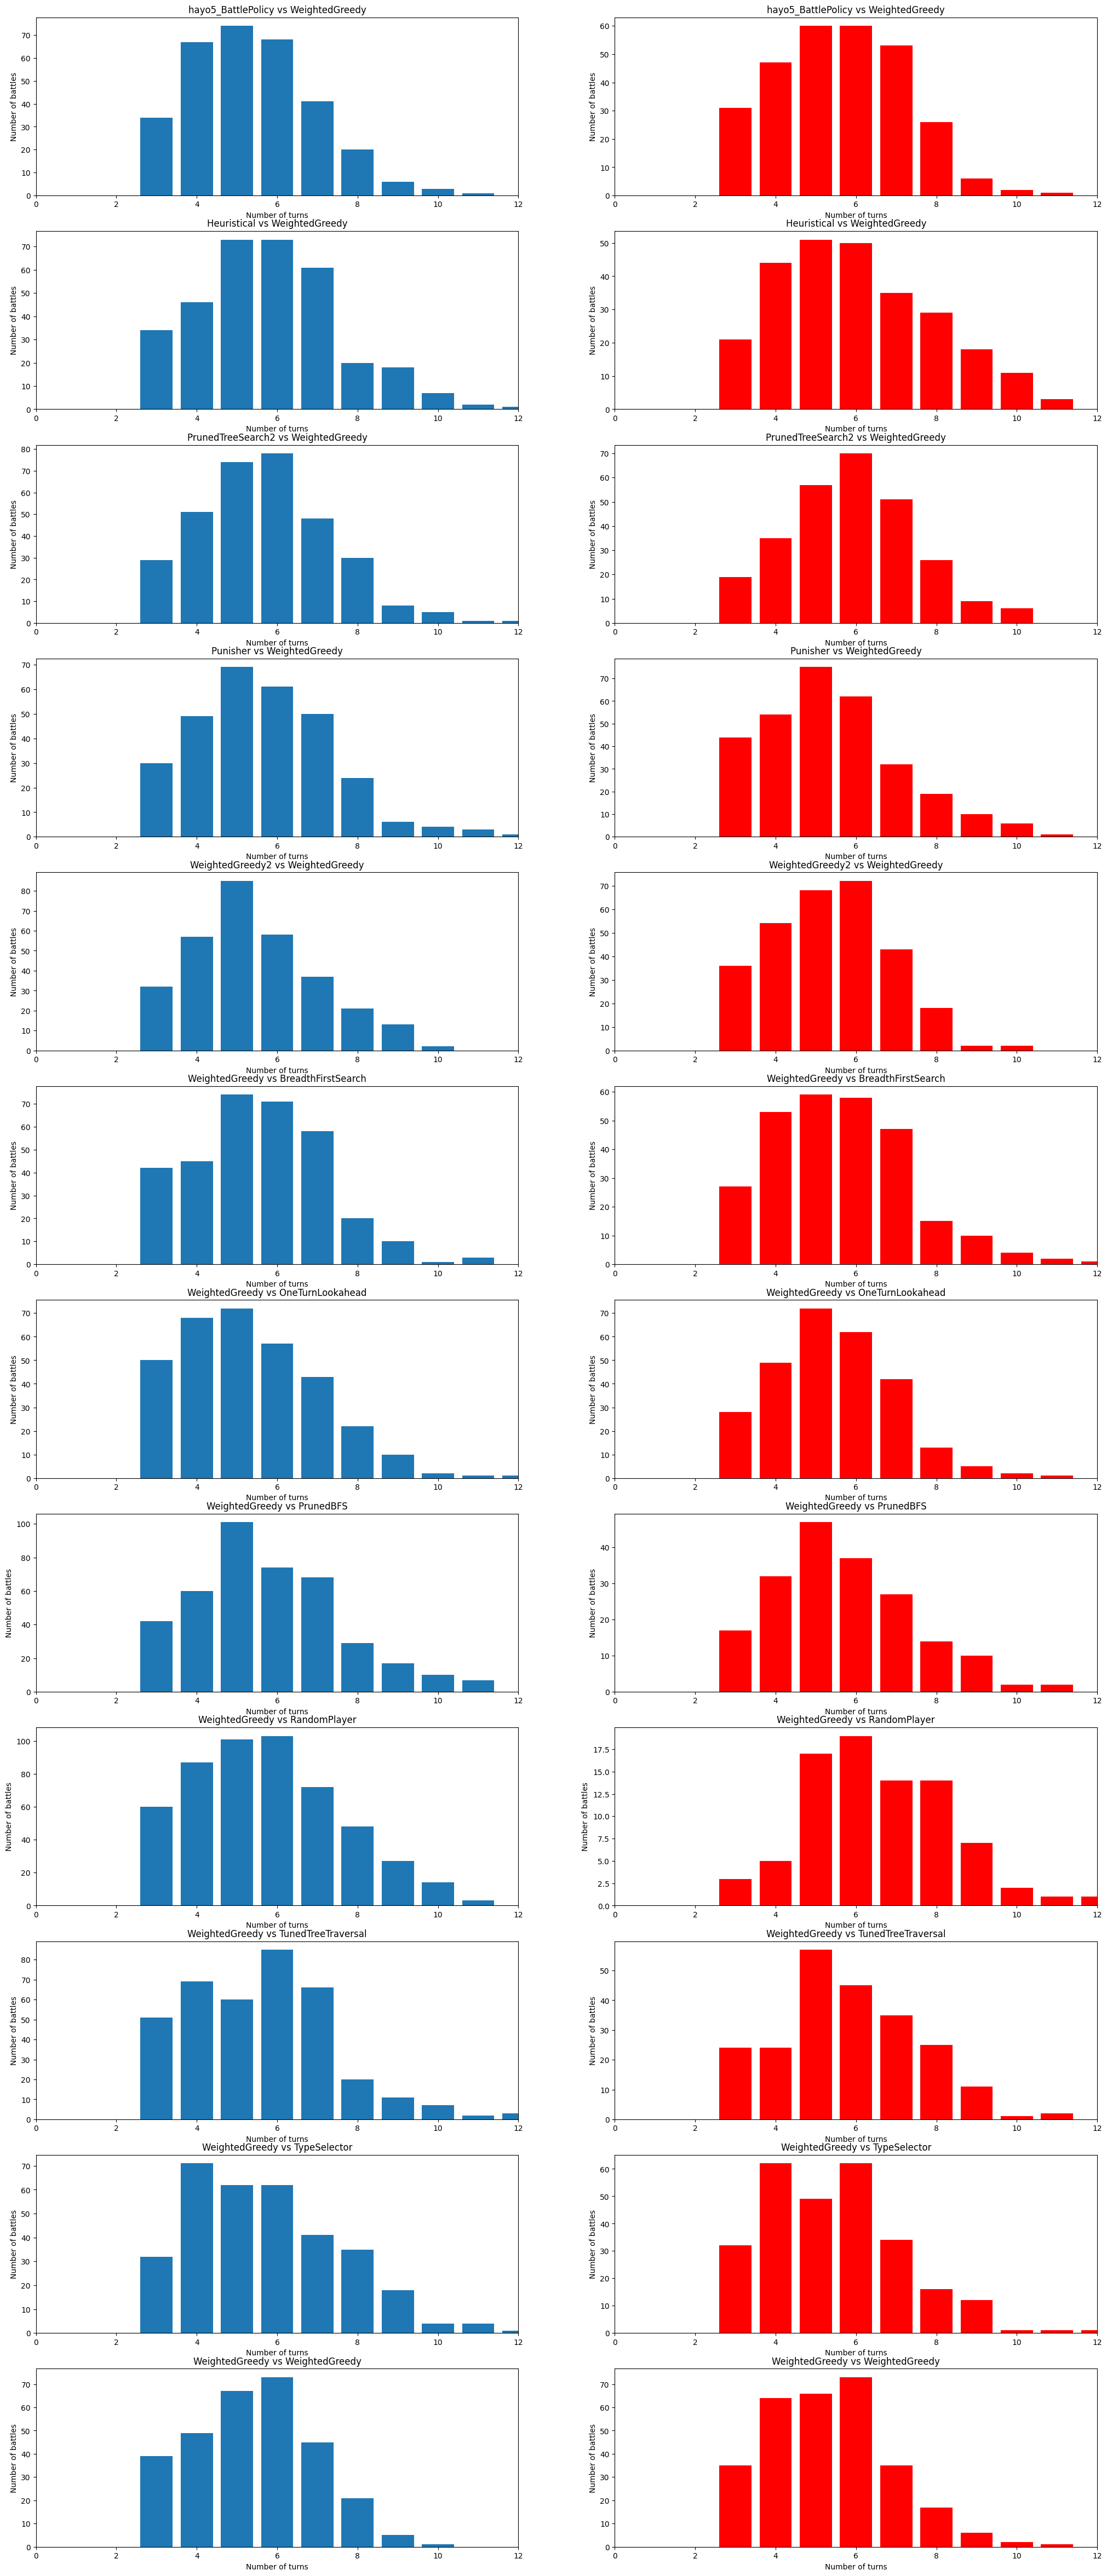

In [28]:
# NUMBER OF TURNS WON/ALL

sys.path.append(os.path.dirname(os.getcwd()))

import utils.scraping_data as s

n = len(policies)

agents = ["WeightedGreedy"]
n_agents = len(agents)

tot_comb = n_agents*n

n_col = 2
n_row = tot_comb

plt.figure(figsize=(25, 60))

i = 0

for d in data:
    if all(ag not in agents for ag in [d["policies_names"][0], d["policies_names"][1]]): continue
    if d["policies_names"][0] == agents[0]: pl = 0
    else: pl = 1

    i += 1
    plt.subplot(n_row, n_col, i)
    games_per_turn = s.get_games_per_turn_count(d, battle_type="won", player=pl)
    ax_x = range(1,len(games_per_turn)+1)
    plt.bar(ax_x, games_per_turn)
    plt.xlim([0, 12])

    plt.title(d["policies_names"][0]+ " vs " + d["policies_names"][1])
    plt.xlabel("Number of turns")
    plt.ylabel("Number of battles")

    i += 1
    plt.subplot(n_row, n_col, i)
    games_per_turn = s.get_games_per_turn_count(d, battle_type="lost", player=pl)
    ax_x = range(1,len(games_per_turn)+1)
    plt.bar(ax_x, games_per_turn, color='red')
    plt.xlim([0, 12])
    
    plt.title(d["policies_names"][0]+ " vs " + d["policies_names"][1])
    plt.xlabel("Number of turns")
    plt.ylabel("Number of battles")

plt.show()



In [51]:
print(policies)

['BreadthFirstSearch', 'Heuristical', 'OneTurnLookahead', 'PrunedBFS', 'PrunedTreeSearch2', 'RandomPlayer', 'TunedTreeTraversal', 'TypeSelector', 'WeightedGreedy', 'WeightedGreedy2']
